In [23]:
import matplotlib.pyplot as plt
from numba import jit, prange, vectorize
from math import gamma
import numpy as np
from matplotlib import cm
import scipy.optimize as op
from scipy.stats import cumfreq, beta
import pandas as pd

In [3]:
from scipy.interpolate import interp1d, interp2d, griddata


# Parameterization

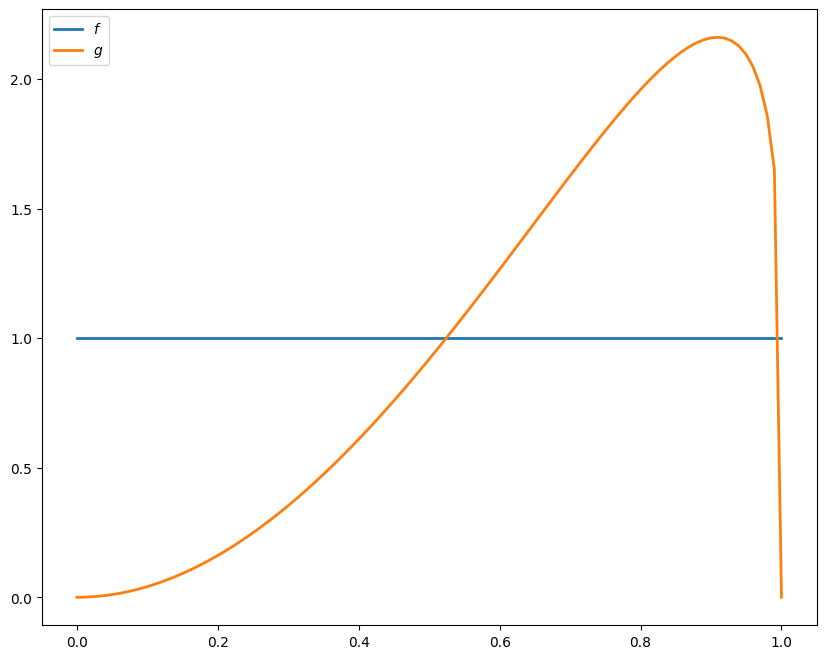

In [4]:
@vectorize
def p(x, a, b):
    r = gamma(a + b) / (gamma(a) * gamma(b))
    return r * x**(a-1) * (1 - x)**(b-1)


x_grid = np.linspace(0, 1, 100)
f = lambda x: p(x, 1, 1)
g = lambda x: p(x, 3, 1.2)

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(x_grid, f(x_grid), label='$f$', lw=2)
ax.plot(x_grid, g(x_grid), label='$g$', lw=2)

ax.legend()
plt.show()

# Method1: VFI

In [5]:
class SearchProblem:
    """
    A class to store a given parameterization of the "offer distribution
    unknown" model.

    """

    def __init__(self,
                 β=0.95,            # Discount factor
                 c=0.3,             # Unemployment compensation
                 F_a=1,
                 F_b=1,
                 G_a=3,
                 G_b=1.2,
                 w_max=1,           # Maximum wage possible
                 w_grid_size=100,
                 π_grid_size=100,
                 mc_size=500):

        self.β, self.c, self.w_max = β, c, w_max

        self.f = jit(lambda x: p(x, F_a, F_b))
        self.g = jit(lambda x: p(x, G_a, G_b))

        self.π_min, self.π_max = 1e-3, 1-1e-3    # Avoids instability
        self.w_grid = np.linspace(0, w_max, w_grid_size)
        self.π_grid = np.linspace(self.π_min, self.π_max, π_grid_size)

        self.mc_size = mc_size

        self.w_f = np.random.beta(F_a, F_b, mc_size)
        self.w_g = np.random.beta(G_a, G_b, mc_size)

The following function takes an instance of the Bellman operator T, and a get_greedy() function to compute the approximate optimal policy from a guess v of the value function



In [6]:
from numba import njit, prange
import numpy as np
@njit
def bilinear_interp(x, y, x_grid, y_grid, v):
    i = np.searchsorted(x_grid, x) - 1
    j = np.searchsorted(y_grid, y) - 1

    # Manual clamping to stay in bounds (Numba-safe)
    i = min(max(i, 0), len(x_grid) - 2)
    j = min(max(j, 0), len(y_grid) - 2)

    x0, x1 = x_grid[i], x_grid[i + 1]
    y0, y1 = y_grid[j], y_grid[j + 1]

    Q11 = v[i, j]
    Q21 = v[i + 1, j]
    Q12 = v[i, j + 1]
    Q22 = v[i + 1, j + 1]

    denom = (x1 - x0) * (y1 - y0)
    if denom == 0:
        return Q11  # fallback to corner value

    return (
        Q11 * (x1 - x) * (y1 - y) +
        Q21 * (x - x0) * (y1 - y) +
        Q12 * (x1 - x) * (y - y0) +
        Q22 * (x - x0) * (y - y0)
    ) / denom



def operator_factory(sp, parallel_flag=True):
    f, g = sp.f, sp.g
    w_f, w_g = sp.w_f, sp.w_g
    β, c = sp.β, sp.c
    mc_size = sp.mc_size
    w_grid, π_grid = sp.w_grid, sp.π_grid

    @njit
    def κ(w, π):
        pf, pg = π * f(w), (1 - π) * g(w)
        π_new = pf / (pf + pg)
        return π_new

    @njit(parallel=parallel_flag)
    def T(v):
        v_new = np.empty_like(v)

        for i in prange(len(w_grid)):
            for j in prange(len(π_grid)):
                w = w_grid[i]
                π = π_grid[j]

                v_1 = w / (1 - β)

                integral_f, integral_g = 0.0, 0.0
                for m in prange(mc_size):
                    π_next_f = κ(w_f[m], π)
                    π_next_g = κ(w_g[m], π)

                    integral_f += bilinear_interp(w_f[m], π_next_f, w_grid, π_grid, v)
                    integral_g += bilinear_interp(w_g[m], π_next_g, w_grid, π_grid, v)

                integral = (π * integral_f + (1 - π) * integral_g) / mc_size
                v_2 = c + β * integral

                v_new[i, j] = max(v_1, v_2)

        return v_new

    @njit(parallel=parallel_flag)
    def get_greedy(v):
        σ = np.empty_like(v)

        for i in prange(len(w_grid)):
            for j in prange(len(π_grid)):
                w = w_grid[i]
                π = π_grid[j]

                v_1 = w / (1 - β)

                integral_f, integral_g = 0.0, 0.0
                for m in prange(mc_size):
                    π_next_f = κ(w_f[m], π)
                    π_next_g = κ(w_g[m], π)

                    integral_f += bilinear_interp(w_f[m], π_next_f, w_grid, π_grid, v)
                    integral_g += bilinear_interp(w_g[m], π_next_g, w_grid, π_grid, v)

                integral = (π * integral_f + (1 - π) * integral_g) / mc_size
                v_2 = c + β * integral

                σ[i, j] = v_1 > v_2

        return σ

    return T, get_greedy


To solve the model we will use the following function that iterates using T to find a fixed point

In [7]:
def solve_model(sp,
                use_parallel=True,
                tol=1e-4,
                max_iter=1000,
                verbose=True,
                print_skip=5):

    """
    Solves for the value function

    * sp is an instance of SearchProblem
    """

    T, _ = operator_factory(sp, use_parallel)

    # Set up loop
    i = 0
    error = tol + 1
    m, n = len(sp.w_grid), len(sp.π_grid)

    # Initialize v
    v = np.zeros((m, n)) + sp.c / (1 - sp.β)

    while i < max_iter and error > tol:
        v_new = T(v)
        error = np.max(np.abs(v - v_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        v = v_new

    if error > tol:
        print("Failed to converge!")
    elif verbose:
        print(f"\nConverged in {i} iterations.")


    return v_new

Error at iteration 5 is 0.6792137595724572.
Error at iteration 10 is 0.10608842522126416.
Error at iteration 15 is 0.021431841534319318.
Error at iteration 20 is 0.004468893184407463.
Error at iteration 25 is 0.0009673369949645405.
Error at iteration 30 is 0.0002094940970831516.

Converged in 33 iterations.


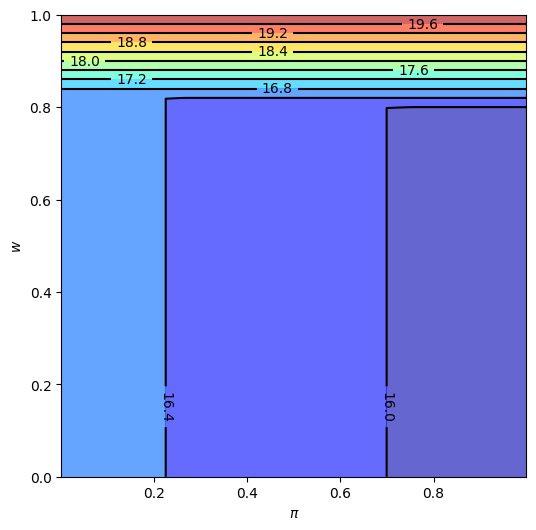

In [8]:
sp = SearchProblem()
v_star = solve_model(sp)
fig, ax = plt.subplots(figsize=(6, 6))
ax.contourf(sp.π_grid, sp.w_grid, v_star, 12, alpha=0.6, cmap=cm.jet)
cs = ax.contour(sp.π_grid, sp.w_grid, v_star, 12, colors="black")
ax.clabel(cs, inline=1, fontsize=10)
ax.set(xlabel=r'$\pi$', ylabel='$w$')

plt.show()

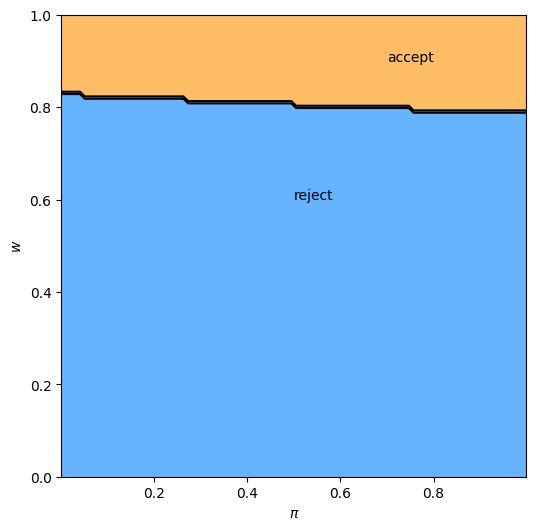

In [9]:
T, get_greedy = operator_factory(sp)
σ_star = get_greedy(v_star)

fig, ax = plt.subplots(figsize=(6, 6))
ax.contourf(sp.π_grid, sp.w_grid, σ_star, 1, alpha=0.6, cmap=cm.jet)
ax.contour(sp.π_grid, sp.w_grid, σ_star, 1, colors="black")
ax.set(xlabel=r'$\pi$', ylabel='$w$')

ax.text(0.5, 0.6, 'reject')
ax.text(0.7, 0.9, 'accept')

plt.show()

# Method 2 -  reservation wage functional equation (RWFE)

We will use iteration with an operator that has the same contraction rate as the Bellman operator, but

one dimensional rather than two dimensional

no maximization step

As a consequence, the algorithm is orders of magnitude faster than VFI.



In [10]:
# builds the reservation-wage operator 𝑄 that maps a current guess 𝜔(𝜋) to a new function Qω(π)
def Q_factory(sp, parallel_flag=True):

    f, g = sp.f, sp.g
    w_f, w_g = sp.w_f, sp.w_g
    β, c = sp.β, sp.c
    mc_size = sp.mc_size
    w_grid, π_grid = sp.w_grid, sp.π_grid

    @jit
    def ω_func(p, ω):
        return np.interp(p, π_grid, ω)

    @jit
    def κ(w, π):
        """
        Updates π using Bayes' rule and the current wage observation w.
        """
        pf, pg = π * f(w), (1 - π) * g(w)
        π_new = pf / (pf + pg)

        return π_new

    @jit(parallel=parallel_flag)
    def Q(ω):
        """

        Updates the reservation wage function guess ω via the operator
        Q.

        """
        ω_new = np.empty_like(ω)

        for i in prange(len(π_grid)):
            π = π_grid[i]
            integral_f, integral_g = 0, 0

            for m in prange(mc_size):
                integral_f += max(w_f[m], ω_func(κ(w_f[m], π), ω))
                integral_g += max(w_g[m], ω_func(κ(w_g[m], π), ω))
            integral = (π * integral_f + (1 - π) * integral_g) / mc_size

            ω_new[i] = (1 - β) * c + β * integral

        return ω_new

    return Q

This code solves the “Offer Distribution Unknown” model by iterating on a guess of the reservation wage function.

Similar to above, we set up a function to iterate with Q to find the fixed point


In [11]:
def solve_wbar(sp,
               use_parallel=True,
               tol=1e-4,
               max_iter=1000,
               verbose=True,
               print_skip=5):

    Q = Q_factory(sp, use_parallel)

    # Set up loop
    i = 0
    error = tol + 1
    m, n = len(sp.w_grid), len(sp.π_grid)

    # Initialize w
    w = np.ones_like(sp.π_grid)

    while i < max_iter and error > tol:
        w_new = Q(w)
        error = np.max(np.abs(w - w_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        w = w_new

    if error > tol:
        print("Failed to converge!")
    elif verbose:
        print(f"\nConverged in {i} iterations.")

    return w_new

Error at iteration 5 is 0.020791134984620152.
Error at iteration 10 is 0.005491409216863419.
Error at iteration 15 is 0.0010808717166547188.
Error at iteration 20 is 0.00020083778250878925.

Converged in 23 iterations.


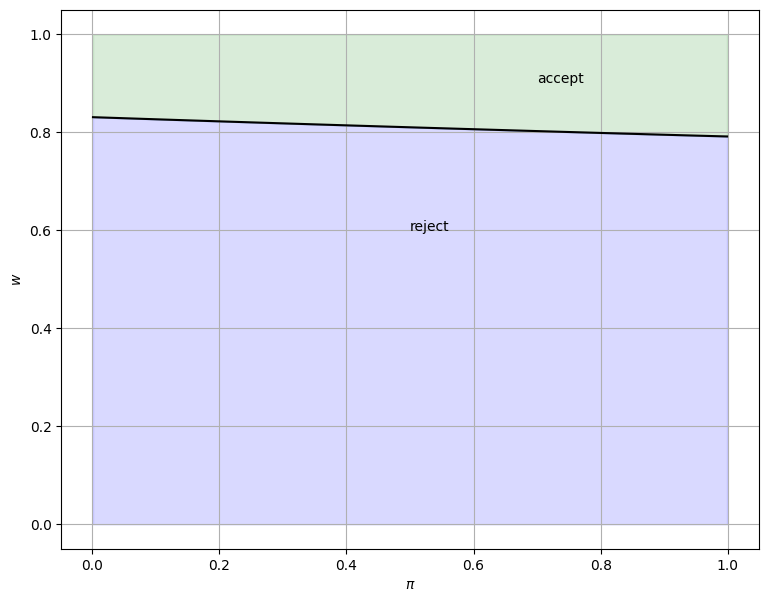

In [12]:
sp = SearchProblem()
w_bar = solve_wbar(sp)

fig, ax = plt.subplots(figsize=(9, 7))

ax.plot(sp.π_grid, w_bar, color='k')
ax.fill_between(sp.π_grid, 0, w_bar, color='blue', alpha=0.15)
ax.fill_between(sp.π_grid, w_bar, sp.w_max, color='green', alpha=0.15)
ax.text(0.5, 0.6, 'reject')
ax.text(0.7, 0.9, 'accept')
ax.set(xlabel=r'$\pi$', ylabel='$w$')
ax.grid()
plt.show()

Generate a table of reservation wage function which can be used in netlogo simulation

In [24]:
# Save reservation wage function
df = pd.DataFrame({"pi": sp.π_grid, "omega": w_bar})
df.to_csv("reservation_wage.csv", index=False)

In [25]:
df

,pi,omega
0,0.001000,0.839451
1,0.011081,0.838603
2,0.021162,0.837819
3,0.031242,0.837072
4,0.041323,0.836341
...,...,...
95,0.958677,0.774429
96,0.968758,0.773789
97,0.978838,0.773150
98,0.988919,0.772513


The next piece of code generates a fun simulation to see what the effect of a change in the underlying distribution on the unemployment rate is.



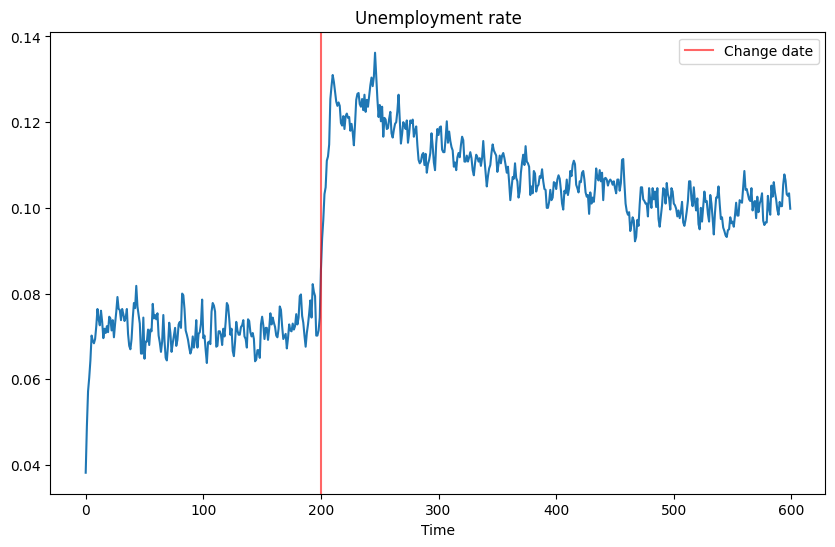

In [14]:
F_a, F_b, G_a, G_b = 1, 1, 3, 1.2

sp = SearchProblem(F_a=F_a, F_b=F_b, G_a=G_a, G_b=G_b)
f, g = sp.f, sp.g

# Solve for reservation wage
w_bar = solve_wbar(sp, verbose=False)

# Interpolate reservation wage function
π_grid = sp.π_grid
w_func = jit(lambda x: np.interp(x, π_grid, w_bar))

@jit
def update(a, b, e, π):
    "Update e and π by drawing wage offer from beta distribution with parameters a and b"

    if e == False:
        w = np.random.beta(a, b)       # Draw random wage
        if w >= w_func(π):
            e = True                   # Take new job
        else:
            π = 1 / (1 + ((1 - π) * g(w)) / (π * f(w)))

    return e, π

@jit
def simulate_path(F_a=F_a,
                  F_b=F_b,
                  G_a=G_a,
                  G_b=G_b,
                  N=5000,       # Number of agents
                  T=600,        # Simulation length
                  d=200,        # Change date
                  s=0.025):     # Separation rate

    """Simulates path of employment for N number of works over T periods"""

    e = np.ones((N, T+1))
    π = np.full((N, T+1), 1e-3)

    a, b = G_a, G_b   # Initial distribution parameters

    for t in range(T+1):

        if t == d:
            a, b = F_a, F_b  # Change distribution parameters

        # Update each agent
        for n in range(N):
            if e[n, t] == 1:                    # If agent is currently employment
                p = np.random.uniform(0, 1)
                if p <= s:                      # Randomly separate with probability s
                    e[n, t] = 0

            new_e, new_π = update(a, b, e[n, t], π[n, t])
            e[n, t+1] = new_e
            π[n, t+1] = new_π

    return e[:, 1:]

d = 200  # Change distribution at time d
unemployment_rate = 1 - simulate_path(d=d).mean(axis=0)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(unemployment_rate)
ax.axvline(d, color='r', alpha=0.6, label='Change date')
ax.set_xlabel('Time')
ax.set_title('Unemployment rate')
ax.legend()
plt.show()

We first define two functions for computing the empirical distributions of unemployment duration and π at the time of employment.

In [15]:
@jit
def empirical_dist(F_a, F_b, G_a, G_b, w_bar, π_grid,
                   N=10000, T=600):
    """
    Simulates population for computing empirical cumulative
    distribution of unemployment duration and π at time when
    the worker accepts the wage offer. For each job searching
    problem, we simulate for two cases that either f or g is
    the true offer distribution.

    Parameters
    ----------

    F_a, F_b, G_a, G_b : parameters of beta distributions F and G.
    w_bar : the reservation wage
    π_grid : grid points of π, for interpolation
    N : number of workers for simulation, optional
    T : maximum of time periods for simulation, optional

    Returns
    -------
    accpet_t : 2 by N ndarray. the empirical distribution of
               unemployment duration when f or g generates offers.
    accept_π : 2 by N ndarray. the empirical distribution of
               π at the time of employment when f or g generates offers.
    """

    accept_t = np.empty((2, N))
    accept_π = np.empty((2, N))

    # f or g generates offers
    for i, (a, b) in enumerate([(F_a, F_b), (G_a, G_b)]):
        # update each agent
        for n in range(N):

            # initial priori
            π = 0.5

            for t in range(T+1):

                # Draw random wage
                w = np.random.beta(a, b)
                lw = p(w, F_a, F_b) / p(w, G_a, G_b)
                π = π * lw / (π * lw + 1 - π)

                # move to next agent if accepts
                if w >= np.interp(π, π_grid, w_bar):
                    break

            # record the unemployment duration
            # and π at the time of acceptance
            accept_t[i, n] = t
            accept_π[i, n] = π

    return accept_t, accept_π

def cumfreq_x(res):
    """
    A helper function for calculating the x grids of
    the cumulative frequency histogram.
    """

    cumcount = res.cumcount
    lowerlimit, binsize = res.lowerlimit, res.binsize

    x = lowerlimit + np.linspace(0, binsize*cumcount.size, cumcount.size)

    return x

Now we define a wrapper function for analyzing job search models with learning under different parameterizations.

In [16]:
def job_search_example(F_a=1, F_b=1, G_a=3, G_b=1.2, c=0.3):
    """
    Given the parameters that specify F and G distributions,
    calculate and display the rejection and acceptance area,
    the evolution of belief π, and the probability of accepting
    an offer at different π level, and simulate and calculate
    the empirical cumulative distribution of the duration of
    unemployment and π at the time the worker accepts the offer.
    """

    # construct a search problem
    sp = SearchProblem(F_a=F_a, F_b=F_b, G_a=G_a, G_b=G_b, c=c)
    f, g = sp.f, sp.g
    π_grid = sp.π_grid

    # Solve for reservation wage
    w_bar = solve_wbar(sp, verbose=False)

    # l(w) = f(w) / g(w)
    l = lambda w: f(w) / g(w)
    # objective function for solving l(w) = 1
    obj = lambda w: l(w) - 1.

    # the mode of beta distribution
    # use this to divide w into two intervals for root finding
    G_mode = (G_a - 1) / (G_a + G_b - 2)
    roots = np.empty(2)
    roots[0] = op.root_scalar(obj, bracket=[1e-10, G_mode]).root
    roots[1] = op.root_scalar(obj, bracket=[G_mode, 1-1e-10]).root

    fig, axs = plt.subplots(2, 2, figsize=(12, 9))

    # part 1: display the details of the model settings and some results
    w_grid = np.linspace(1e-12, 1-1e-12, 100)

    axs[0, 0].plot(l(w_grid), w_grid, label='$l$', lw=2)
    axs[0, 0].vlines(1., 0., 1., linestyle="--")
    axs[0, 0].hlines(roots, 0., 2., linestyle="--")
    axs[0, 0].set_xlim([0., 2.])
    axs[0, 0].legend(loc=4)
    axs[0, 0].set(xlabel='$l(w)=f(w)/g(w)$', ylabel='$w$')

    axs[0, 1].plot(sp.π_grid, w_bar, color='k')
    axs[0, 1].fill_between(sp.π_grid, 0, w_bar, color='blue', alpha=0.15)
    axs[0, 1].fill_between(sp.π_grid, w_bar, sp.w_max, color='green', alpha=0.15)
    axs[0, 1].text(0.5, 0.6, 'reject')
    axs[0, 1].text(0.7, 0.9, 'accept')

    W = np.arange(0.01, 0.99, 0.08)
    Π = np.arange(0.01, 0.99, 0.08)

    ΔW = np.zeros((len(W), len(Π)))
    ΔΠ = np.empty((len(W), len(Π)))
    for i, w in enumerate(W):
        for j, π in enumerate(Π):
            lw = l(w)
            ΔΠ[i, j] = π * (lw / (π * lw + 1 - π) - 1)

    q = axs[0, 1].quiver(Π, W, ΔΠ, ΔW, scale=2, color='r', alpha=0.8)

    axs[0, 1].hlines(roots, 0., 1., linestyle="--")
    axs[0, 1].set(xlabel=r'$\pi$', ylabel='$w$')
    axs[0, 1].grid()

    axs[1, 0].plot(f(x_grid), x_grid, label='$f$', lw=2)
    axs[1, 0].plot(g(x_grid), x_grid, label='$g$', lw=2)
    axs[1, 0].vlines(1., 0., 1., linestyle="--")
    axs[1, 0].hlines(roots, 0., 2., linestyle="--")
    axs[1, 0].legend(loc=4)
    axs[1, 0].set(xlabel='$f(w), g(w)$', ylabel='$w$')

    axs[1, 1].plot(sp.π_grid, 1 - beta.cdf(w_bar, F_a, F_b), label='$f$')
    axs[1, 1].plot(sp.π_grid, 1 - beta.cdf(w_bar, G_a, G_b), label='$g$')
    axs[1, 1].set_ylim([0., 1.])
    axs[1, 1].grid()
    axs[1, 1].legend(loc=4)
    axs[1, 1].set(xlabel=r'$\pi$', ylabel=r'$\mathbb{P}\{w > \overline{w} (\pi)\}$')

    plt.show()

    # part 2: simulate empirical cumulative distribution
    accept_t, accept_π = empirical_dist(F_a, F_b, G_a, G_b, w_bar, π_grid)
    N = accept_t.shape[1]

    cfq_t_F = cumfreq(accept_t[0, :], numbins=100)
    cfq_π_F = cumfreq(accept_π[0, :], numbins=100)

    cfq_t_G = cumfreq(accept_t[1, :], numbins=100)
    cfq_π_G = cumfreq(accept_π[1, :], numbins=100)

    fig, axs = plt.subplots(2, 1, figsize=(12, 9))

    axs[0].plot(cumfreq_x(cfq_t_F), cfq_t_F.cumcount/N, label="f generates")
    axs[0].plot(cumfreq_x(cfq_t_G), cfq_t_G.cumcount/N, label="g generates")
    axs[0].grid(linestyle='--')
    axs[0].legend(loc=4)
    axs[0].title.set_text('CDF of duration of unemployment')
    axs[0].set(xlabel='time', ylabel='Prob(time)')

    axs[1].plot(cumfreq_x(cfq_π_F), cfq_π_F.cumcount/N, label="f generates")
    axs[1].plot(cumfreq_x(cfq_π_G), cfq_π_G.cumcount/N, label="g generates")
    axs[1].grid(linestyle='--')
    axs[1].legend(loc=4)
    axs[1].title.set_text('CDF of π at time worker accepts wage and leaves unemployment')
    axs[1].set(xlabel='π', ylabel='Prob(π)')

    plt.show()

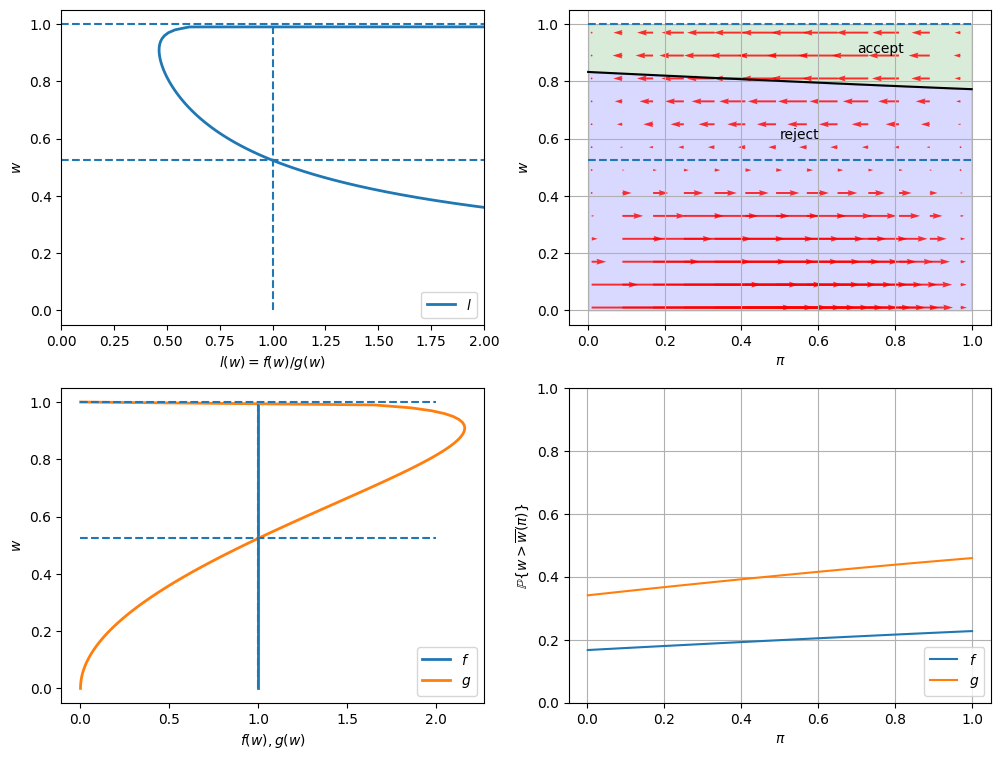

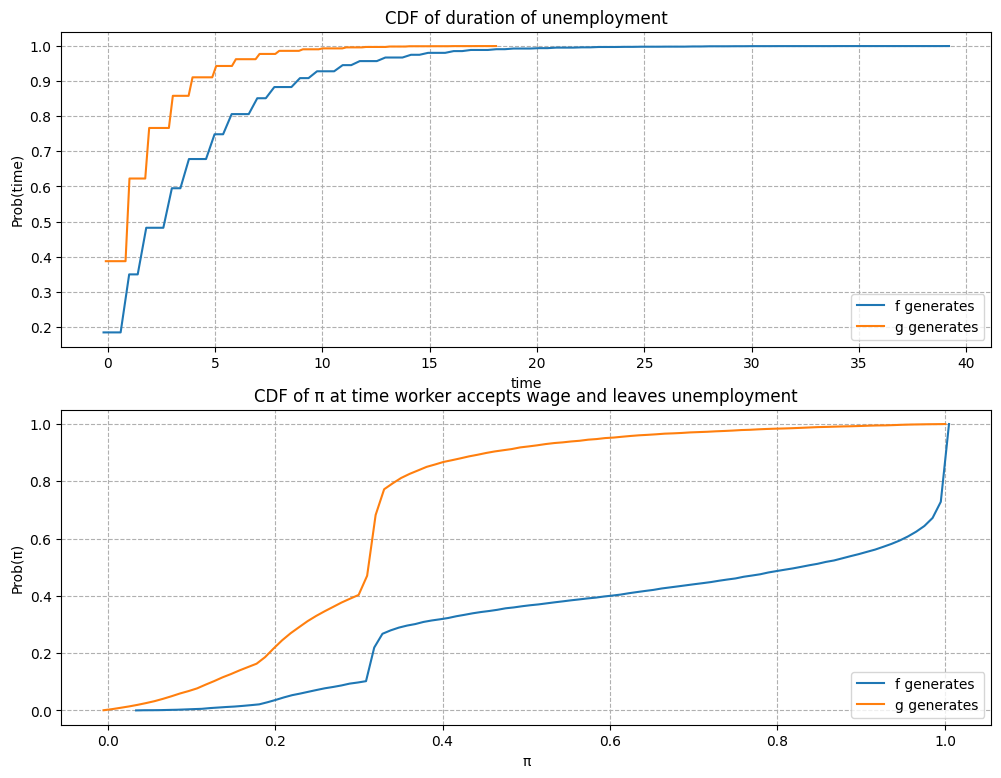

In [17]:
job_search_example()

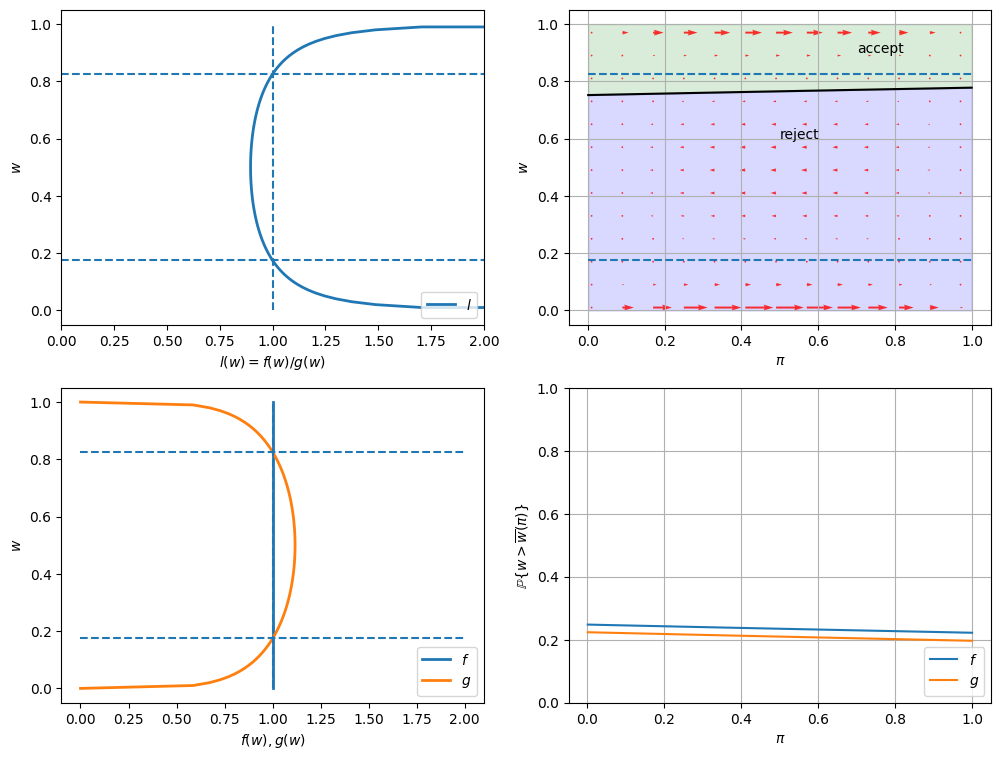

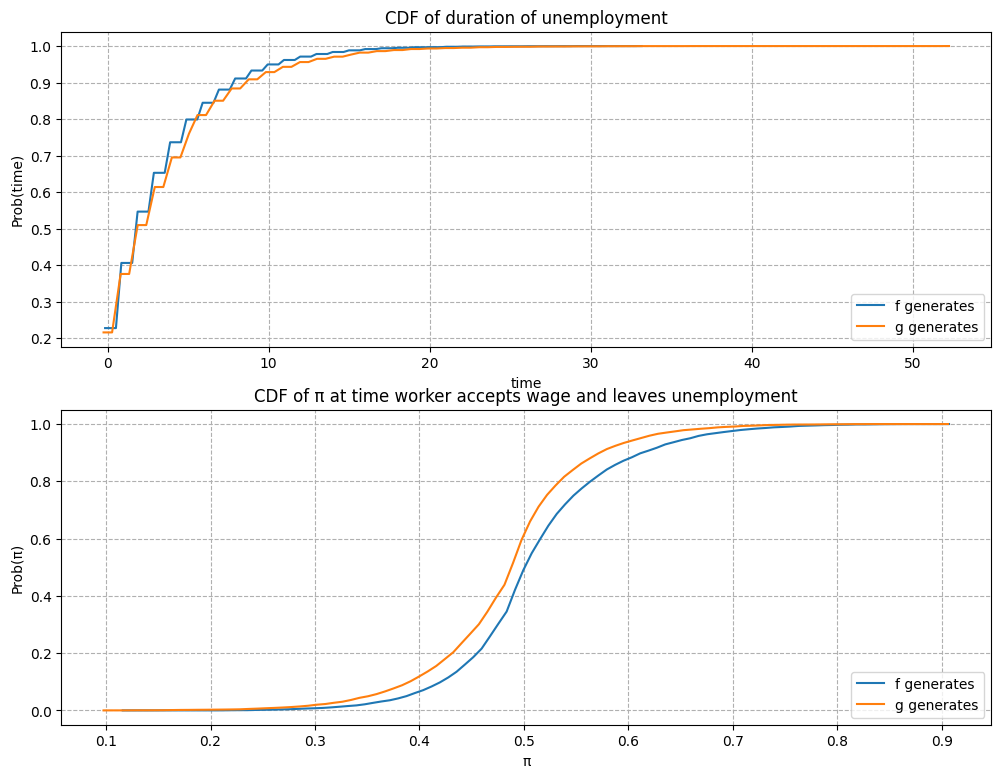

In [18]:
job_search_example(1, 1, 1.2, 1.2, 0.3)

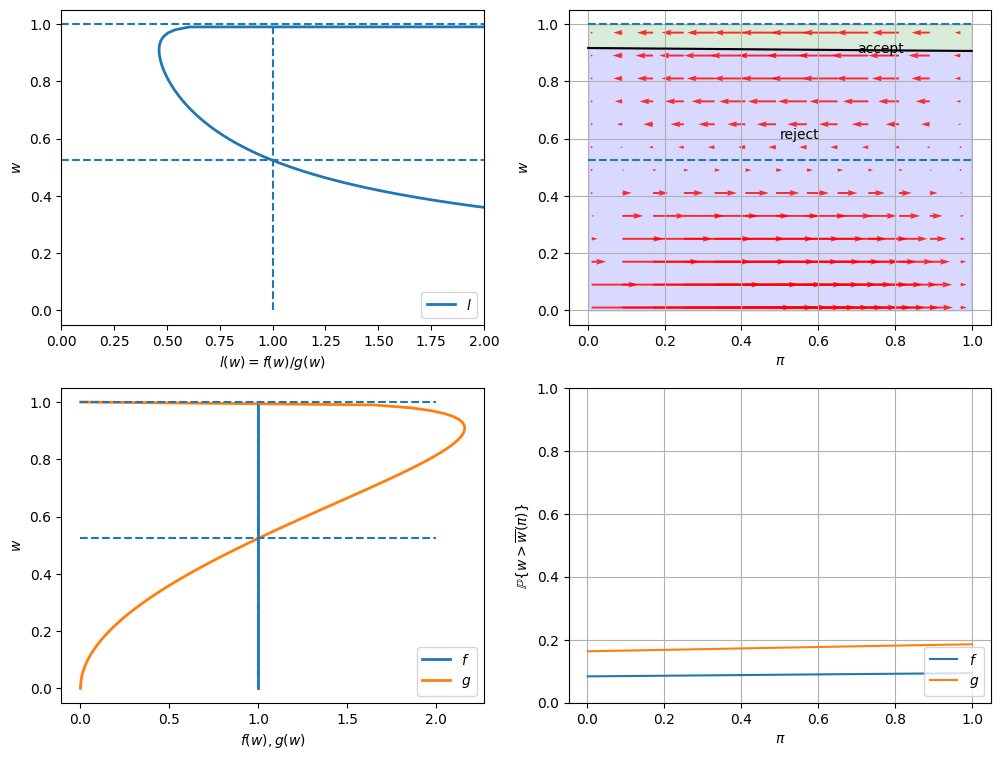

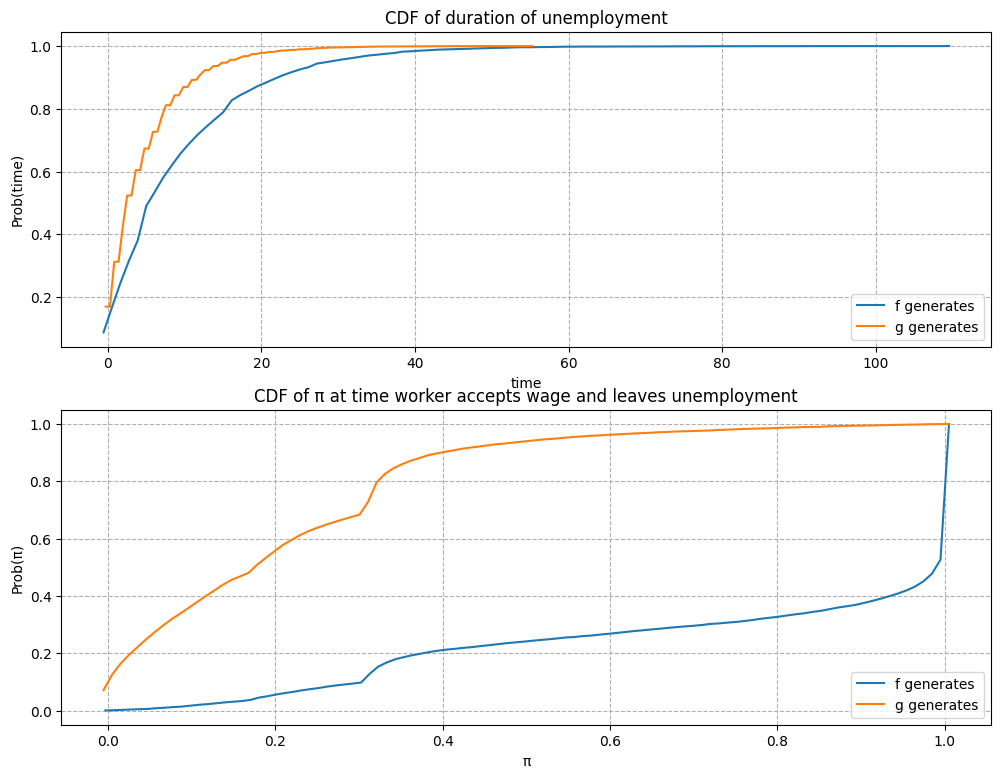

In [19]:
job_search_example(1, 1, 3, 1.2, c=0.8)

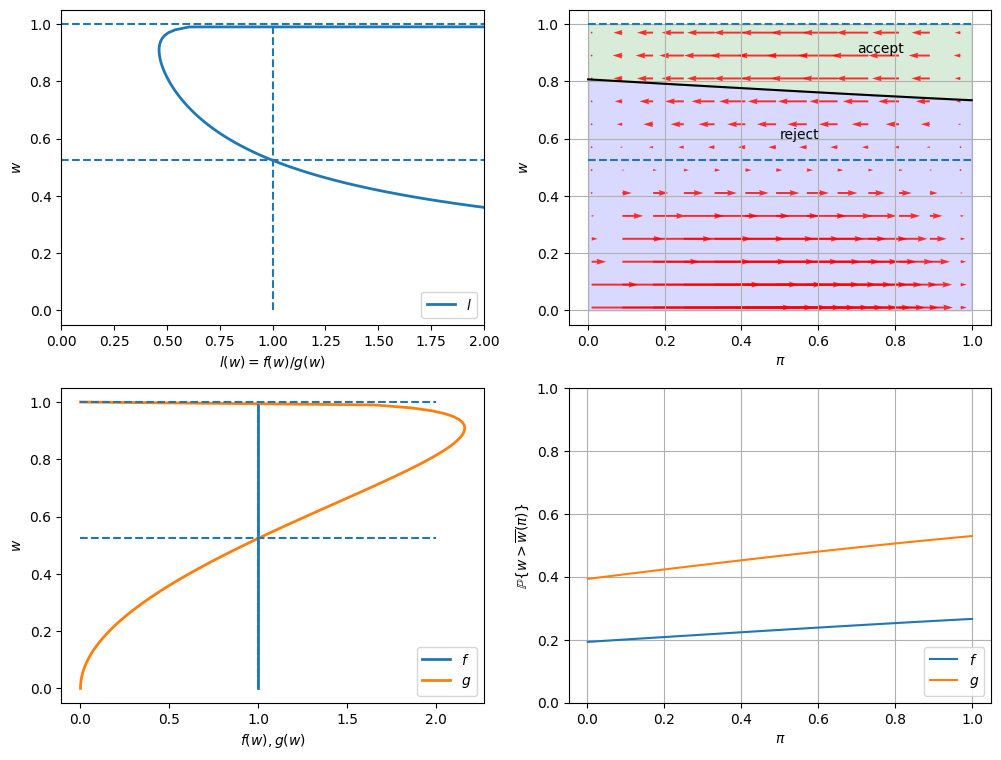

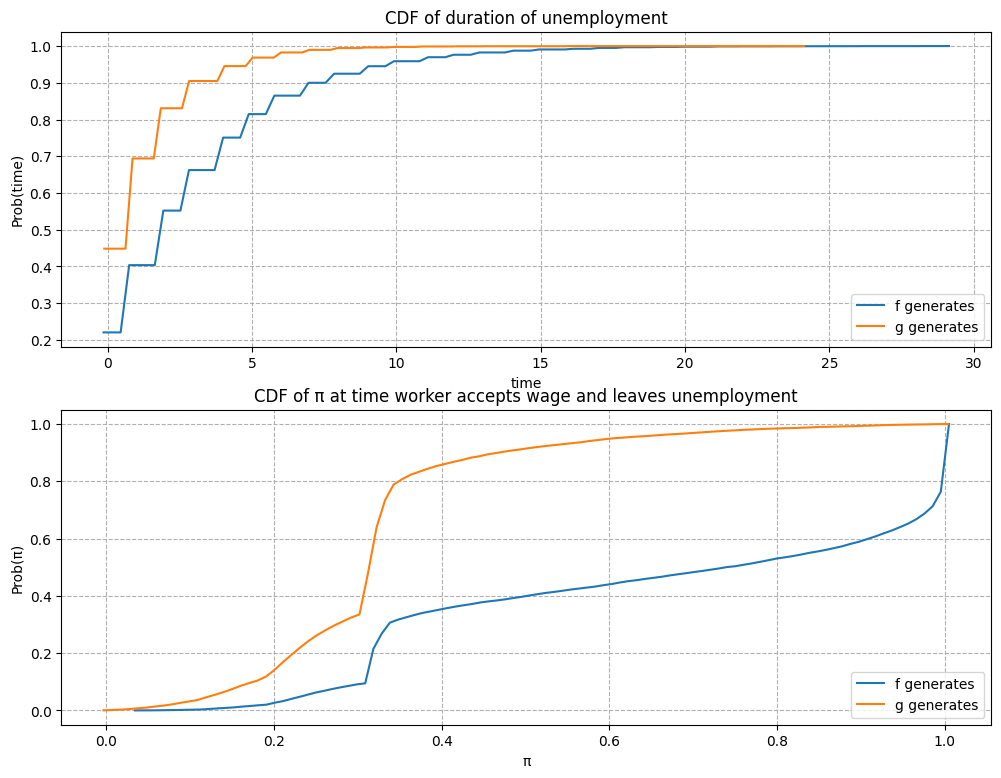

In [20]:
job_search_example(1, 1, 3, 1.2, c=0.1)